<Figure size 432x288 with 0 Axes>

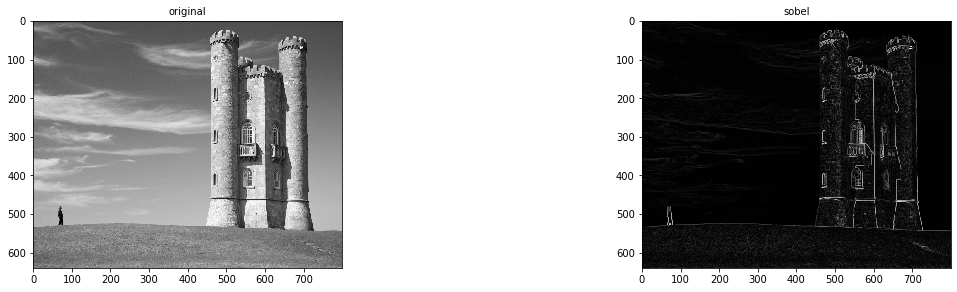

In [25]:
#!/usr/bin/env python
# coding: utf-8

# In[19]:


import sys
import numpy as np
from imageio import imread, imwrite
from scipy.ndimage.filters import convolve
from PIL import Image
import PySimpleGUI as sg
import os, fnmatch, glob
import imageio
from matplotlib.image import imread
import os, fnmatch
import glob
from tqdm import trange
from numba import jit
import os
import warnings
warnings.filterwarnings('ignore')
import time
import json
from helpers import transform_images, create_new_path, create_gif, create_dirs, save_energy_map

#!pip install pysimplegui


#Did not touch the below 3 methods
#Dynamic Programming Stuff
#--------------------------------------------------------#
#--------------------------------------------------------#
#--------------------------------------------------------#
def calc_energy(img, operator):
    #https://en.wikipedia.org/wiki/Sobel_operator
    #
    if operator == 'Sobel':
        dx = np.array([
            [1.0, 2.0, 1.0],
            [0.0, 0.0, 0.0],
            [-1.0, -2.0, -1.0],
        ])
        dy = np.array([
            [1.0, 0.0, -1.0],
            [2.0, 0.0, -2.0],
            [1.0, 0.0, -1.0],
        ])
    if operator == 'Sobel_Feldman':
        dx = np.array([
            [3.0, 0.0, -3.0],
            [10.0, 0.0, -10.0],
            [3.0, 0.0, -3.0],
        ])

        dy = np.array([
            [3.0, 10.0, 3.0],
            [0.0, 0.0, 0.0],
            [-3.0, -10.0, -3.0],
        ])
    if operator == 'Scharr':
        dx = np.array([
            [47.0, 0.0, -47.0],
            [162.0, 0.0, -162.0],
            [47.0, 0.0, -47.0],
        ])

        dy = np.array([
            [47.0, 162.0, 47.0],
            [0.0, 0.0, 0.0],
            [-47.0, -162.0, -47.0],
        ])
    # Stack Filter for all dims
    
    filter_dx = np.stack([dx] * 3, axis=2)
    filter_dy = np.stack([dy] * 3, axis=2)
    
    #img to array
    img = img.astype('float32')
    
    #Convolve filter over image channels
    #http://cs.brown.edu/courses/cs129/results/proj3/taox/
    #For each color channel, the energy is calculated by adding the 
    #absolute value of the gradient in the x direction to the absolute value of the gradient in the y direction.
    convolved = np.absolute(convolve(img, filter_dx)) + np.absolute(
        convolve(img, filter_dy))

    energy = convolved.sum(axis=2)
    #Energy returns image gradient with filter convolved over each dim
    return energy


#--------------------------------------------------------#
@jit
def minimum_seam(img, operator = 'Sobel'):
    r, c, _ = img.shape
    energy_map = calc_energy(img, operator)

    M = energy_map.copy() #Deep copy so we don't have ties between arrays
    #instantiate cost matrix. This is the same shape as the images energy map
    backtrack = np.zeros_like(M, dtype=np.int)

    for i in range(1, r): #ignore top row. Cost matrix values for top row are = to energy map
        for j in range(0, c):
            # http://cs.brown.edu/courses/cs129/results/proj3/taox/
            #If a neighboring pixel is not available due to the left or right edge, 
            #it is simply not used in the minimum of top neighbors calculation. 
            if j == 0:
                idx = np.argmin(M[i - 1, j:j + 2]) 
                backtrack[i, j] = idx + j
                min_energy = M[i - 1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtrack


#--------------------------------------------------------#
@jit
def carve_column(img, operator = 'Sobel'):
    r, c, _ = img.shape

    M, backtrack = minimum_seam(img, operator)

    # Create a (r, c) matrix filled with the value True
    # We'll be removing all pixels from the image which
    # have False later
    mask = np.ones((r, c), dtype=np.bool)

    # Find the position of the smallest element in the
    # last row of M
    j = np.argmin(M[-1])

    for i in reversed(range(r)):
        # Mark the pixels for deletion
        mask[i, j] = False
        j = backtrack[i, j]

    # Since the image has 3 channels, we convert our
    # mask to 3D
    mask = np.stack([mask] * 3, axis=2)

    # Delete all the pixels marked False in the mask,
    # and resize it to the new image dimensions
    img = img[mask].reshape((r, c - 1, 3))

    return img 

#--------------------------------------------------------#
#Progressively Carve and Store Images at checkpoints
#--------------------------------------------------------#
def crop_c(img, scale_c, save_progress = 10, rotation=False, operator = 'Sobel'):
    '''
    Backbone for main carve method.
    Parms:
        img: arr (pass through),
        scale_c: float, rescale proportion [0,100]
        rotation: bool, flag on if row-wise carving
    '''
    r, c, _ = img.shape
    new_c = int(scale_c * c)

    for i in range(c - new_c):  # use range if you don't want to use tqdm
                                #Need this to share Progress Bar for Seam Carving
        sg.OneLineProgressMeter('Stay Tuned.. Carving Image', i + 1, c - new_c,
                                'key')

        img = carve_column(img, operator = operator)
                                #Store image after every k cols/rows carved for gif generation
        if i % save_progress == 0:
                                #Handle Rotation Partitions for Row-wise Carving
            if rotation:
                imageio.imsave('temp/{}'.format('a' + str(i) + '.png'),
                               np.rot90(img, 3, (0, 1)))
            else:
                imageio.imsave('temp/{}'.format('a' + str(i) + '.png'), img)

                                #Create Gif from images partitioned through carving
    create_gif()
    return img


#--------------------------------------------------------#
#Handle Row-Wise Carving
#--------------------------------------------------------#
def crop_r(img, scale_r , save_progress = 10, operator = 'Sobel'):
    '''
    Backbone for main carve method.
    Uses crop_c under the hood
    '''
    #Meta Heuristic
    img = np.rot90(img, 1, (0, 1)) #Rotate 90degrees
    img = crop_c(img, scale_r, save_progress = save_progress, rotation=True, operator= operator) #Carve
    img = np.rot90(img, 3, (0, 1)) #Rotate Back
    return img


#--------------------------------------------------------#
#Main Carving Method
#--------------------------------------------------------#
def carve(img, dim, output, scale=0.5 , save_progress = 10, operator = 'Sobel'):
    '''
    Main Method for Seam Carving
    parms:
        img: str; image path. Passed through from GUI.
        dim: str; 'Row' or 'Column'. Passed through from GUI dict.
        output: str; final resting place of carved image.
        scale: float; desired resize. Passed through from GUI.
    returns:
        saves carved image in desired new path.
    '''
    img = imageio.imread(img)
    if dim == 'Column':
        new = crop_c(img, scale_c=scale, save_progress = save_progress, operator = operator)
        imageio.imsave(output, new)

    if dim == 'Row':
        new = crop_r(img, scale_r=scale, save_progress = save_progress, operator = operator)
        imageio.imsave(output, new)






if __name__ == '__main__':
    try:
        #Some Cleaning of Dir + Fetching
        #--------------------------------------------------------#
        directory = os.getcwd() + '\\' +'images' #Get CWD
        transform_images()  #Transform images
        #Get list of images in CWD
        files = [
            item for sublist in
            [glob.glob(directory + ext) for ext in ["/*.png", "/*.jpg", "/*.gif"]]
            for item in sublist
        ]
        #--------------------------------------------------------#
        #Create Temp Storage
        #--------------------------------------------------------#
        create_dirs()
        #--------------------------------------------------------#

        #Window One Design
        #--------------------------------------------------------#
        sg.ChangeLookAndFeel('Material1')

        # ------ Menu Definition ------ #
        menu_def = [['File', ['Exit']]]

        # ------ Column Definition ------ #
        column1 = [
            [
                sg.Text('Column 1',
                        background_color='#F7F3EC',
                        justification='center',
                        size=(10, 1))
            ],
            [sg.Spin(values=('Spin Box 1', '2', '3'), initial_value='Spin Box 1')],
            [sg.Spin(values=('Spin Box 1', '2', '3'), initial_value='Spin Box 2')],
            [sg.Spin(values=('Spin Box 1', '2', '3'), initial_value='Spin Box 3')]
        ]

        layout = [
            [sg.Menu(menu_def, tearoff=True)],
            [
                sg.Text('Seam Carving - content-aware image resizing',
                        size=(40, 1),
                        justification='center',
                        font=("Helvetica", 24),
                        relief=sg.RELIEF_RIDGE)
            ],
             # ------ Folder Selector ------ #
            [
                sg.Text(
                    'Choose A Folder',
                    size=(20, 1),
                    auto_size_text=True,
                    justification='center',
                    tooltip=
                    'Directory Selection. Defaults to current Working Directory.'),
                sg.InputText(directory, size=(80, 1)),
                #sg.FolderBrowse()
            ],
             # ------ Image Selector ------ #
            [
                sg.Text(
                    'Choose An Image',
                    size=(20, 1),
                    auto_size_text=True,
                    justification='center',
                    tooltip=
                    'Image Selection. Gui can only display .png files. jpgs run through conversion apriori.'
                ),
                sg.InputCombo(([i for i in files]),
                              default_value=files[0],
                              size=(80, 1))
            ],
            [
                sg.Frame(layout=[
                    # ------ Dimension Selector ------ #
                    [
                        sg.Text('Choose A Dim To Carve Along',
                                size=(25, 1),
                                auto_size_text=True,
                                justification='center',
                                tooltip='Row or Column Carving'),
                        sg.InputCombo(('Column', 'Row'),
                                      default_value='Column',
                                      size=(20, 1))
                    ],
                    # ------ Filter Selector ------ #

                    [
                        sg.Text('Choose A Filter To Use',
                                size=(25, 1),
                                auto_size_text=True,
                                justification='center',
                                tooltip='Filter Selection'),
                        sg.InputCombo(('Sobel', 'Sobel_Feldman', 'Scharr'),
                                      default_value='Sobel',
                                      size=(20, 1))
                    ],
                    # ------ Rescale Size Selector ------ #
                    [
                        sg.Text('Rescaling Factor',
                                size=(25, 1),
                                auto_size_text=True,
                                justification='center',
                                tooltip='Filter Selection'),
                        sg.Slider(range=(1, 100),
                                  orientation='h',
                                  size=(34, 20),
                                  default_value=50)
                    ],
                    # ------ Save Progress Slider ------ #
                    [
                        sg.Text('Save Every K Seams',
                                size=(25, 1),
                                auto_size_text=True,
                                justification='center',
                                tooltip='Filter Selection'),
                        sg.Slider(range=(1, 20),
                                  orientation='h',
                                  size=(34, 20),
                                  default_value=10)
                    ],
                ],
                         title='Options',
                         title_color='red',
                         relief=sg.RELIEF_SUNKEN,
                         tooltip='Set Parameters to Feed into SC algo')
            ],
            [sg.Text('_' * 80)],
            [sg.Button('Launch'),
             sg.Cancel()],
        ]

        window = sg.Window('Seam Carving',
                           layout,
                           default_element_size=(40, 1),
                           grab_anywhere=False)

        window2_active = False

        event, values = window.Read()

        if event == 'Exit':
            window.Close()
        #--------------------------------------------------------#
        #Where the magic happens
        #--------------------------------------------------------#

        if not window2_active and event == 'Launch':
            #Dump Formfill Data b4 overwritten & Reload
            #--------------------------------------------------------#
            with open('file.txt', 'w') as file:
                file.write(json.dumps(values))
            vals = json.load(open("file.txt"))
            '''
            vals structure (Exported Forms):
            [1]: Main Folder. Change to image folder
            [2]: Image Path. Change to show subpath per [1]
            [3]: Row/Column parameter
            [4]: Filter Type. To do. Defaults to Sobel?
            [5]: Rescale Size. Resize to [0,1] range.
            [6]: How often to checkpoint an image during carving. Defaults to 10. >10 is slow on gif creation
            '''
            #Run Main Carving Method
            #--------------------------------------------------------#

            output = 'carved/' + create_new_path(
                vals['2'])  #specify carved output location

            carve(vals['2'], dim=vals['3'], output=output,
                  scale=vals['5'] / 100, save_progress= vals['6'], operator= vals['4']) #run seam carving
            
            save_energy_map(vals['2'])

            window2_active = True

            #Layout for window 2 specified. Show Original and Carved image side by side.
            #--------------------------------------------------------#
            layout2 = [
                #[sg.PopupAnimated('gif\movie.gif')],
                [
                    sg.Text('Original Image'),
                    sg.Image(r"{}".format(vals['2'])),
                    sg.Image(r"{}".format(output)),
                    sg.Text('Carved Image'),
                    
                ],
                [sg.Image(r"{}".format('energy/energymap.png'))],
                [sg.Button('Exit')],
            ]

            #Popup Window Showing Carve Progression. Max Time on screen is fixed to 30 seconds before disappearing
            #--------------------------------------------------------#
            timeout = time.time() + 10  #30 second popup limit
            frames = len(os.listdir("temp/"))  #Count of frames in Gif
            while True:
                if time.time() < timeout:
                    sg.PopupAnimated(image_source=r"gif\movie.gif",
                                     time_between_frames=(30 / frames * 1000) / 6,
                                     message="Showing Carve Progression. 10 Second Loop")
                else:
                    break

            sg.PopupAnimated(None)
            #Launch Second Window
            #--------------------------------------------------------#

            window2 = sg.Window('Window 2', resizable=True).Layout(layout2)

            #EXIT Second Window
            #--------------------------------------------------------#
            if window2_active:
                ev2, vals2 = window2.read()
                if ev2 is None or ev2 == 'Exit':
                    window2_active = False
                    window2.close()

        #EXIT Base Window
        #--------------------------------------------------------#
        window.Close()

    except:
        sg.Popup('Something went wrong')
        os.remove(output)
        window.Close()


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.0029729 , 0.0029729 ,
        0.        ],
       [0.        , 0.00098039, 0.00219222, ..., 0.0029729 , 0.0029729 ,
        0.        ],
       ...,
       [0.        , 0.01985929, 0.02884383, ..., 0.03251188, 0.14333348,
        0.        ],
       [0.        , 0.01539078, 0.02999805, ..., 0.11878809, 0.06840849,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

<Figure size 432x288 with 0 Axes>

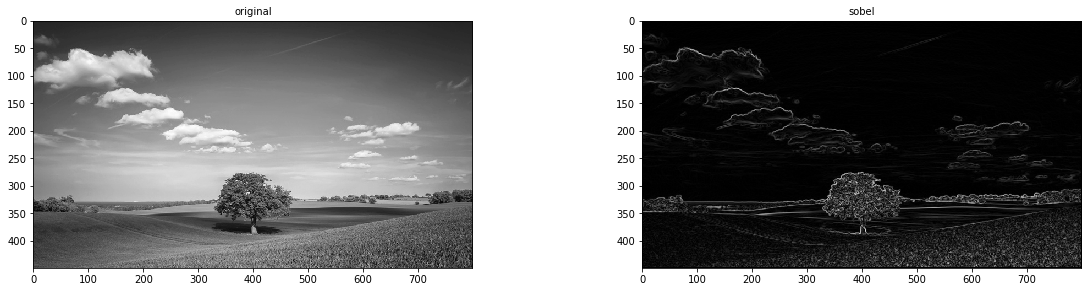

In [4]:

im = rgb2gray(imageio.imread('images/tree.png')) # RGB image to gray scale
plt.gray()
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(im)
plt.title('original', size=10)
plt.subplot(222)
edges = filters.sobel(im)
plt.imshow(edges)
plt.title('sobel', size=10)
plt.savefig('energymap.png', dpi = 75, bbox_inches='tight')
edges.shape
edges

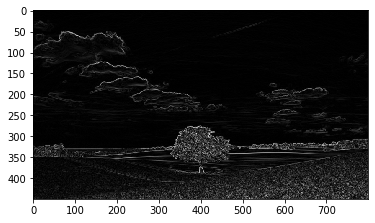

In [23]:
plt.imshow(filters.scharr(im))